# Setup

## Colab-Specific

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import os
os.chdir('/content/drive/MyDrive/_Colab/UdacityHealth/Pneumonia')

In [15]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage import io
from tqdm import tqdm
import scipy.stats



ROOT_CSV = 'csv/'
ROOT_DATA = '/data/'

## Download Data

In [10]:
!mkdir ~/.kaggle/
!mv  /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [11]:
!kaggle datasets download -d nih-chest-xrays/data -p /data/

100% 42.0G/42.0G [04:55<00:00, 112MB/s]
100% 42.0G/42.0G [04:55<00:00, 153MB/s]


In [12]:
!unzip -q /data/data.zip -d /data
!rm /data/data.zip

## Prepare Dataset

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Take the early processing of the metadata from the EDA:

In [26]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

#all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df = pd.read_csv(ROOT_CSV + 'Data_Entry_2017_EDA.csv')
all_xray_df['has_pneumonia'] = all_xray_df['Finding_Pneumonia'].map({0:'no',1:'yes'})
all_image_paths = all_xray_df.path.values
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
#all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 111863 , Total Headers 111863


Image_filename  Follow-up  Patient_ID  Patient_Age Patient_Gender  \
79758  00019643_033.png         33       19643           31              F   
14370  00003741_004.png          4        3741           70              M   
70203  00017356_008.png          8       17356           29              F   

      View_Position  Image_width  Image_height  ImagePixelSpacing_x  \
79758            AP         2500          2048                0.168   
14370            PA         2500          2048                0.168   
70203            AP         2500          2048                0.168   

       ImagePixelSpacing_y  ...  Finding_Infiltration  Finding_Mass  \
79758                0.168  ...                     1             0   
14370                0.168  ...                     0             0   
70203                0.168  ...                     0             0   

       Finding_No_Finding  Finding_Nodule  Finding_Pleural_Thickening  \
79758                   0               0                           0   
14370                   1               0                           0   
70203                   0               0                           0   

       Finding_Pneumonia  Finding_Pneumothorax  n_diseases  \
79758                  0                     0           1   
14370                  0                     0           0   
70203                  0                     0           1   

                                            path  has_pneumonia  
79758  /data//images_009/images/00019643_033.png             no  
14370  /data//images_002/images/00003741_004.png             no  
70203  /data//images_008/images/00017356_008.png             no  

[3 rows x 28 columns]

## Create your training and testing data:

In [27]:
all_xray_df.head(2)

Image_filename  Follow-up  Patient_ID  Patient_Age Patient_Gender  \
0  00000001_000.png          0           1           58              M   
1  00000001_001.png          1           1           58              M   

  View_Position  Image_width  Image_height  ImagePixelSpacing_x  \
0            PA         2682          2749                0.143   
1            PA         2894          2729                0.143   

   ImagePixelSpacing_y  ...  Finding_Infiltration  Finding_Mass  \
0                0.143  ...                     0             0   
1                0.143  ...                     0             0   

   Finding_No_Finding  Finding_Nodule  Finding_Pleural_Thickening  \
0                   0               0                           0   
1                   0               0                           0   

   Finding_Pneumonia  Finding_Pneumothorax  n_diseases  \
0                  0                     0           1   
1                  0                     0           2   

                                        path  has_pneumonia  
0  /data//images_001/images/00000001_000.png             no  
1  /data//images_001/images/00000001_001.png             no  

[2 rows x 28 columns]

In [28]:
def create_splits(df, test_size=0.2, column_stratify=None):
    from sklearn.model_selection import train_test_split

    df_to_use = df.copy()
    if column_stratify:
      total_peneumonia = df_to_use.loc[df_to_use[column_stratify] == 1].shape[0]
      total_db = df_to_use.shape[0]
      n_train = int(total_peneumonia * (1 - test_size))
      
      
      train_data = df_to_use.loc[df_to_use[column_stratify] == 1].sample(n_train)
      train_data = train_data.append(df_to_use.loc[df[column_stratify] == 0].sample(n_train))

      # in order to avoid data leakage from Train and Test
      df_to_use.drop(train_data.index, axis=0, inplace=True)
      possible_leakage = df_to_use.loc[(df_to_use.Patient_ID.isin((train_data.Patient_ID.unique()))) & (df_to_use[column_stratify] == 1)]
      train_data = train_data.append(possible_leakage).reset_index(drop=True)
      df_to_use.drop(possible_leakage.index, axis=0, inplace=True)
      print(f'there was a possible leakage of: {possible_leakage.shape[0]}')

      n_test = len(df_to_use.loc[df_to_use[column_stratify] == 1])
      n_test_negative = int((total_db * n_test) / total_peneumonia)
      n_test_negative = n_test * 5
    
      val_data = df_to_use.loc[df_to_use[column_stratify] == 1].sample(n_test)
      val_data = val_data.append(df_to_use.loc[df_to_use[column_stratify] == 0].sample(n_test_negative))
    else:
      train_data, val_data = train_test_split(df, test_size=test_size)
    
    
    return train_data, val_data


In [29]:
train_df, valid_df = create_splits(all_xray_df, column_stratify='Finding_Pneumonia')
n_train_pneum, n_train_no_pneum = len(train_df.loc[train_df['Finding_Pneumonia'] == 1]), len(train_df.loc[train_df['Finding_Pneumonia'] == 0])
n_valid_pneum, n_valid_no_pneum = len(valid_df.loc[valid_df['Finding_Pneumonia'] == 1]), len(valid_df.loc[valid_df['Finding_Pneumonia'] == 0])

n_df_pneum, n_df_no_pneum = len(all_xray_df.loc[all_xray_df['Finding_Pneumonia'] == 1]), len(all_xray_df.loc[all_xray_df['Finding_Pneumonia'] == 0])

print(f'Total db: {all_xray_df.shape[0]:>8} total elements ; {n_df_pneum:>5} pneumonia; {n_df_no_pneum:>7} ; {n_df_pneum/all_xray_df.shape[0]*100:>5.2f}% pneumonia')
print(f'Train db: {train_df.shape[0]:>8} total elements ; {n_train_pneum:>5} pneumonia; {n_train_no_pneum:>7} ; {n_train_pneum/train_df.shape[0]*100:>5.2f}% pneumonia')
print(f'Valid db: {valid_df.shape[0]:>8} total elements ; {n_valid_pneum:>5} pneumonia; {n_valid_no_pneum:>7} ; {n_valid_pneum/valid_df.shape[0]*100:>5.2f}% pneumonia')


there was a possible leakage of: 143
Total db:   111863 total elements ;  1429 pneumonia;  110434 ;  1.28% pneumonia
Train db:     2429 total elements ;  1286 pneumonia;    1143 ; 52.94% pneumonia
Valid db:      858 total elements ;   143 pneumonia;     715 ; 16.67% pneumonia


### Age Distribution

Check the Age Distribution from DataSet

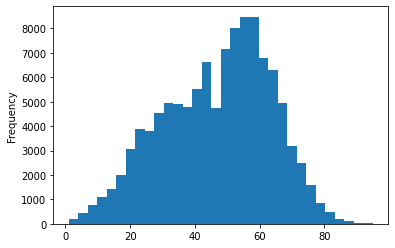

In [30]:
all_xray_df['Patient_Age'].plot(kind='hist', bins = 32,)

Check the Age Distribution from Train DataSet

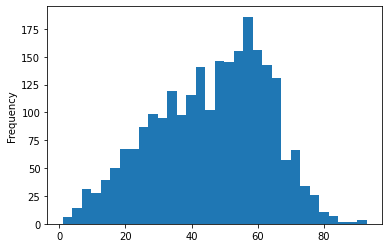

In [31]:
train_df['Patient_Age'].plot(kind='hist', bins = 32,)

Check the Age Distribution from Valid DataSet

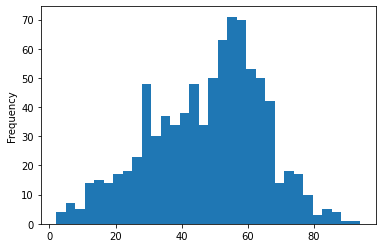

In [32]:
valid_df['Patient_Age'].plot(kind='hist', bins = 32,)

### Gender Distribution

Age Distribution from DataSet

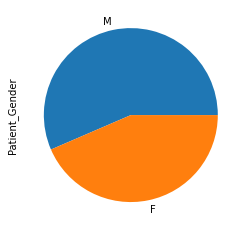

In [33]:
all_xray_df['Patient_Gender'].value_counts().plot(kind='pie')

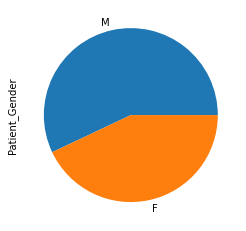

In [34]:
train_df['Patient_Gender'].value_counts().plot(kind='pie')

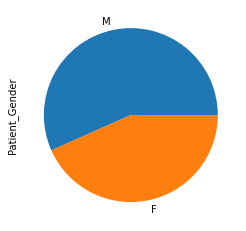

In [35]:
valid_df['Patient_Gender'].value_counts().plot(kind='pie')

### Image Position Distribution

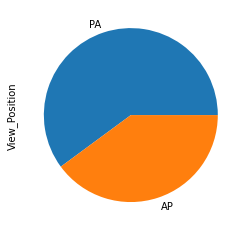

In [36]:
all_xray_df['View_Position'].value_counts().plot(kind='pie')

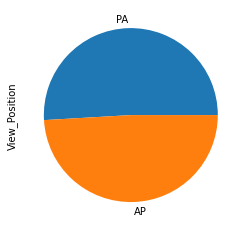

In [37]:
train_df['View_Position'].value_counts().plot(kind='pie')

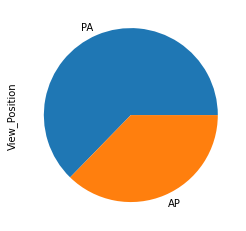

In [38]:
valid_df['View_Position'].value_counts().plot(kind='pie')

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [39]:
def my_image_augmentation(train=True, hor_flip=True, height_shift=0.1, rotation_range=20, shear_range=0.1, brightness_range=[0.2, 1.0], zoom=0.1):
    from  tensorflow.keras.preprocessing.image import ImageDataGenerator
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    if train:
      my_idg = ImageDataGenerator(rescale = 1. / 255.0,
                                  horizontal_flip = hor_flip, 
                                  vertical_flip = False, 
                                  height_shift_range = height_shift,
                                  width_shift_range = height_shift, 
                                  rotation_range = rotation_range,
                                  shear_range = shear_range,
                                  zoom_range = zoom)
    else: # val
      my_idg = ImageDataGenerator(rescale = 1. / 255.0)

    
    return my_idg

def make_train_val_gen(train_df, train=True, x_col='path', y_col='has_pneumonia', img_size=IMG_SIZE, batch_size=BATCH_SIZE, val_batch=2048):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    # Apply image generator to generate more images
    train_gen = my_image_augmentation(train).flow_from_dataframe(dataframe=train_df, 
                                        directory=None, 
                                        x_col = x_col,
                                        y_col = y_col, 
                                        class_mode = 'binary', 
                                        target_size = img_size,
                                        batch_size = batch_size if train else val_batch)


    return train_gen


In [40]:
## May want to pull a single large batch of random validation data for testing after each epoch:

train_gen = make_train_val_gen(train_df)
val_gen = make_train_val_gen(valid_df, train=False)

valX, valY = val_gen.next()

Found 2429 validated image filenames belonging to 2 classes.
Found 858 validated image filenames belonging to 2 classes.


In [49]:
samples = train_df.sample(16)
t_x, t_y = samples.path.values, samples.Finding_Pneumonia.values


In [52]:
t_x = [io.imread(a) for a in t_x]

In [55]:
t_x[0].shape

(1024, 1024)

##### Without Augmentation 

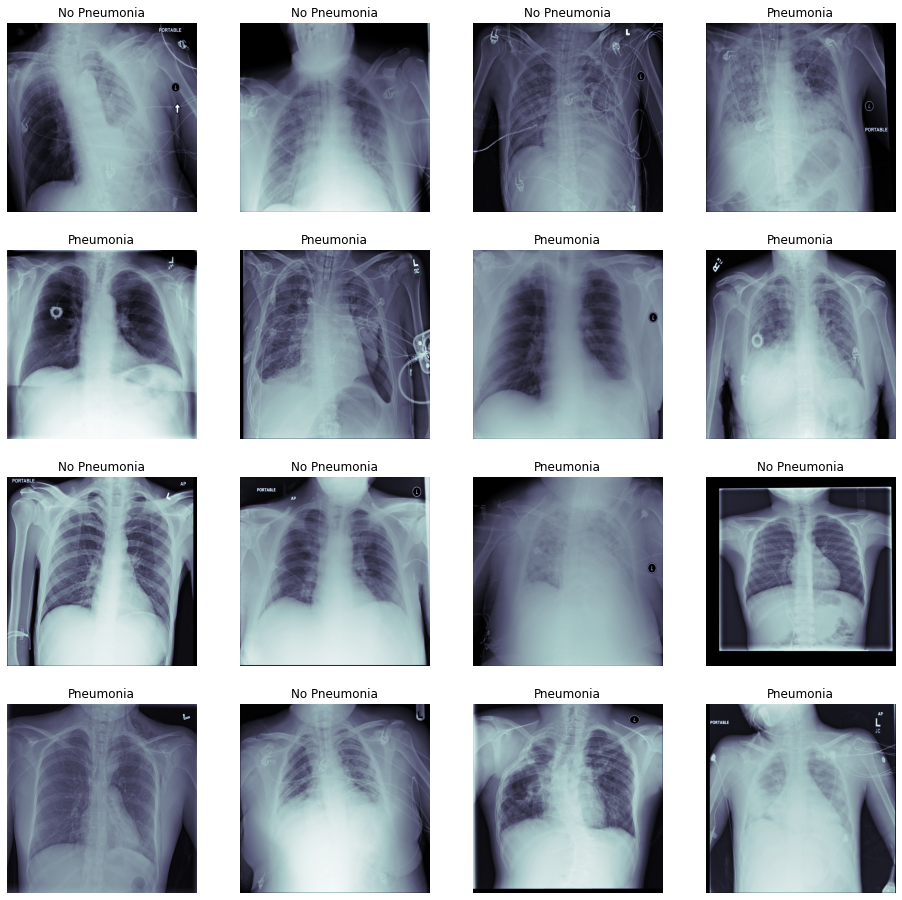

In [56]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

#samples = train_df.sample(16)
#t_x, t_y = samples.
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

##### With Augmentation 

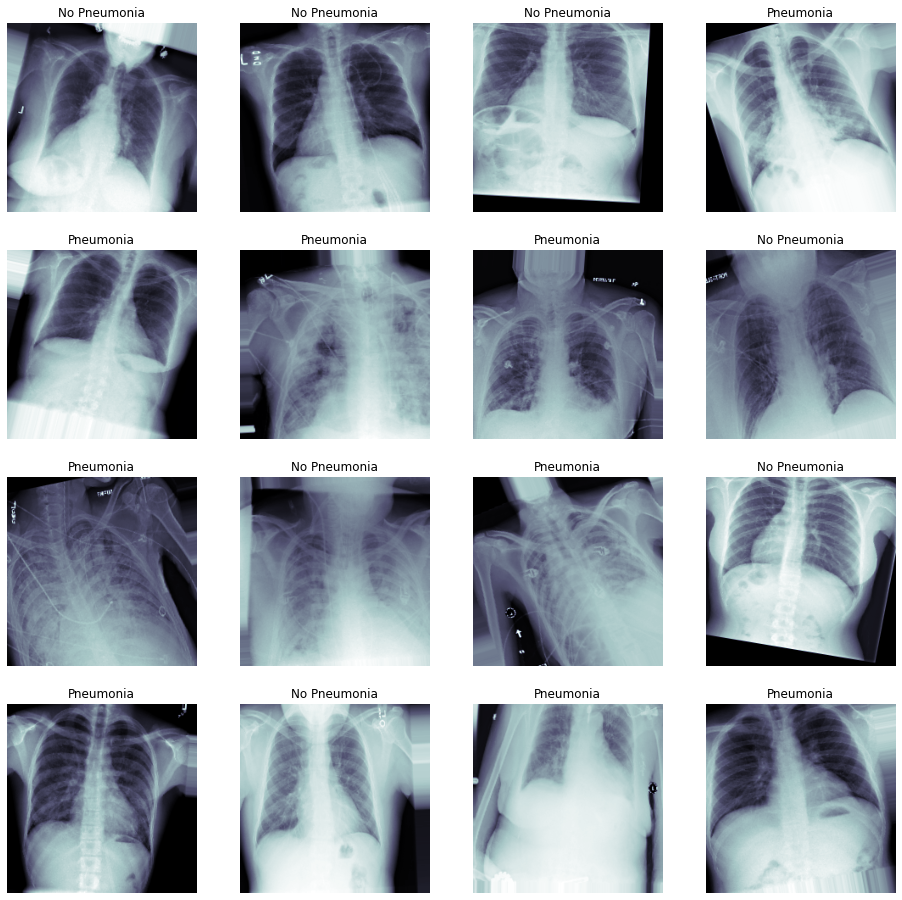

In [ ]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(traina_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

**Joao_Oliveira**: From my previous Computer vision knowledge I know that there are other options of pre-trained model besides VGG16 (not that there's anything wrong with VGG16).
Therefor after searching, I stumpled across the article from Patrick Ting1
, Anish Kasam2 and Kevin Lan [article](https://www.biomedscijournal.com/articles/abse-aid1015.pdf) which lead me to choose **ResNet50 pre-trained model** 

In [ ]:
from keras.applications.resnet import ResNet50 
ResNet50(include_top=True, weights='imagenet').summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
from keras.applications.vgg16 import VGG16
VGG16(include_top=True, weights='imagenet').summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:

def load_pretrained_model(model_name='ResNet'):
    from keras.applications.resnet import ResNet50 
    from keras.applications.vgg16 import VGG16
    from keras.models import Sequential, Model
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    if model_name == 'ResNet':



      model_res = ResNet50(include_top=True, weights='imagenet')

      transfer_layer = model_res.get_layer('avg_pool')
      model = Model(inputs=model_res.input, outputs=transfer_layer.output)
      for layer in model.layers[:-4]:
          layer.trainable = False

    elif  model_name == 'VGG16':
      model_vgg = VGG16(include_top=True, weights='imagenet')
      transfer_layer = model_vgg.get_layer('block5_pool')
      model = Model(inputs = model_vgg.input, outputs = transfer_layer.output)
      for layer in model.layers[:17]:
        layer.trainable = False
    else: 
      model = None

    return model


In [ ]:
from keras.metrics import SensitivityAtSpecificity
import tensorflow as tf
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import keras


def build_my_model(layers, dropout, model_name=None, init_lr=1e-2):
    from keras.layers import Dense, Dropout, Flatten
    from keras.models import Sequential, Model
    from tensorflow.keras.optimizers import Adam


    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo

    if model_name: pre_trainedmodel = load_pretrained_model(model_name)
    else: pre_trainedmodel = load_pretrained_model()

    my_model = Sequential()

    my_model.add(pre_trainedmodel)
    my_model.add(Flatten())

    for l, d in zip(layers, dropout):
      my_model.add(Dense(l, activation='relu'))
      if d > 0: my_model.add(Dropout(d))

    my_model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=init_lr)
    loss = 'binary_crossentropy'
    metrics = ['AUC',
              'binary_accuracy',
              keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity'),
              keras.metrics.FalseNegatives(name="fn"),
              keras.metrics.FalsePositives(name="fp"),
              keras.metrics.TrueNegatives(name="tn"),
              keras.metrics.TruePositives(name="tp"),
              keras.metrics.Precision(name="precision"),
              keras.metrics.Recall(name="recall"),
            ]

    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

def training(my_model, train_gen, valX, valY, METRIC_MONITOR = 'sensitivity',METRIC_MONITOR_MODE = 'max',  model_name='x_ray_class', epochs=100):
    from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

    weight_path=f"{model_name}_my_model.best.hdf5"

    checkpoint = ModelCheckpoint(weight_path, 
                                monitor= METRIC_MONITOR, 
                                verbose=1, 
                                save_best_only=True, 
                                mode= METRIC_MONITOR_MODE, 
                                save_weights_only = True)

    early = EarlyStopping(monitor=METRIC_MONITOR, 
                          mode=METRIC_MONITOR_MODE, 
                          patience=10)

    reduce_lr = ReduceLROnPlateau(monitor=METRIC_MONITOR, factor=0.3,
                                  patience=2, min_lr=1e-5)

    callbacks_list = [checkpoint, early, reduce_lr]

    history = my_model.fit(train_gen,
                          validation_data = (valX, valY), 
                          epochs = epochs, 
                          callbacks = callbacks_list)
    
    return history

In [ ]:
def save_history(path, name, history):
    if not os.path.exists(path): os.mkdir(path)
    if not os.path.exists(f"{path}/{name}/"): os.mkdir(f"{path}/{name}/")

    import json

    for key in history.__dict__['history'].keys():
        if key == 'lr': continue
        json.dump(history.__dict__['history'][key], open(f"{path}/{name}/{key}.json", 'w'))


# Start training! 

## ResNet50

### **Loss** for monitor LR and EarlyStop

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'loss', 'min', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.8745 - auc: 0.4890 - binary_accuracy: 0.4911 - sensitivity: 0.4275 - fn: 646.0000 - fp: 588.0000 - tn: 555.0000 - tp: 636.0000 - precision: 0.5196 - recall: 0.4961
Epoch 1: loss improved from inf to 1.87447, saving model to resnet_loss_3_layers__my_model.best.hdf5
76/76 [==============================] - 70s 869ms/step - loss: 1.8745 - auc: 0.4890 - binary_accuracy: 0.4911 - sensitivity: 0.4275 - fn: 646.0000 - fp: 588.0000 - tn: 555.0000 - tp: 636.0000 - precision: 0.5196 - recall: 0.4961 - val_loss: 0.7106 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6926 - auc: 0.4742 - binary_accuracy: 0.5274 - sensitivity: 0.2800 - fn: 11.0000 - fp: 1135.0000 - tn: 8.0000 - tp: 1271.0000 - 

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'loss', 'min', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.6031 - auc: 0.5029 - binary_accuracy: 0.5151 - sensitivity: 0.4540 - fn: 372.0000 - fp: 804.0000 - tn: 339.0000 - tp: 910.0000 - precision: 0.5309 - recall: 0.7098
Epoch 1: loss improved from inf to 1.60314, saving model to resnet_loss_2_layers__my_model.best.hdf5
76/76 [==============================] - 66s 810ms/step - loss: 1.6031 - auc: 0.5029 - binary_accuracy: 0.5151 - sensitivity: 0.4540 - fn: 372.0000 - fp: 804.0000 - tn: 339.0000 - tp: 910.0000 - precision: 0.5309 - recall: 0.7098 - val_loss: 0.7243 - val_auc: 0.4918 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.3537 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6951 - auc: 0.4946 - binary_accuracy: 0.5208 - sensitivity: 0.4033 - fn: 298.0000 - fp: 864.0000 - tn: 279.0000 - tp: 984.0000 - pre

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'loss', 'min', [512], [0.5]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.0792 - auc: 0.5017 - binary_accuracy: 0.5138 - sensitivity: 0.4930 - fn: 365.0000 - fp: 814.0000 - tn: 329.0000 - tp: 917.0000 - precision: 0.5298 - recall: 0.7153
Epoch 1: loss improved from inf to 1.07919, saving model to resnet_loss_1_layers__my_model.best.hdf5
76/76 [==============================] - 64s 787ms/step - loss: 1.0792 - auc: 0.5017 - binary_accuracy: 0.5138 - sensitivity: 0.4930 - fn: 365.0000 - fp: 814.0000 - tn: 329.0000 - tp: 917.0000 - precision: 0.5298 - recall: 0.7153 - val_loss: 0.7401 - val_auc: 0.5014 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6921 - auc: 0.5088 - binary_accuracy: 0.5122 - sensitivity: 0.5156 - fn: 147.0000 - fp: 1036.0000 - tn: 107.0000 - tp: 1135.0000

### **Sensitivity** for monitor LR and EarlyStop

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'sensitivity', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'sensitivity', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.1669 - auc: 0.4739 - binary_accuracy: 0.4887 - sensitivity: 0.4228 - fn: 445.0000 - fp: 795.0000 - tn: 348.0000 - tp: 837.0000 - precision: 0.5129 - recall: 0.6529
Epoch 1: sensitivity improved from -inf to 0.42278, saving model to resnet_sensitivity_2_layers__my_model.best.hdf5
76/76 [==============================] - 66s 808ms/step - loss: 1.1669 - auc: 0.4739 - binary_accuracy: 0.4887 - sensitivity: 0.4228 - fn: 445.0000 - fp: 795.0000 - tn: 348.0000 - tp: 837.0000 - precision: 0.5129 - recall: 0.6529 - val_loss: 0.7035 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6939 - auc: 0.4986 - binary_accuracy: 0.5307 - sensitivity: 0.4548 - fn: 34.0000 - fp: 1104.0000 - tn: 39.0000 - 

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'sensitivity', 'max', [512], [0.5]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

### **Binary Accuracy** for monitor LR and EarlyStop

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'binary_accuracy', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'binary_accuracy', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.2719 - auc: 0.4753 - binary_accuracy: 0.4903 - sensitivity: 0.4501 - fn: 422.0000 - fp: 814.0000 - tn: 329.0000 - tp: 860.0000 - precision: 0.5137 - recall: 0.6708
Epoch 1: binary_accuracy improved from -inf to 0.49031, saving model to resnet_binary_accuracy_2_layers__my_model.best.hdf5
76/76 [==============================] - 66s 815ms/step - loss: 1.2719 - auc: 0.4753 - binary_accuracy: 0.4903 - sensitivity: 0.4501 - fn: 422.0000 - fp: 814.0000 - tn: 329.0000 - tp: 860.0000 - precision: 0.5137 - recall: 0.6708 - val_loss: 0.6976 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6928 - auc: 0.4974 - binary_accuracy: 0.5303 - sensitivity: 0.4641 - fn: 30.0000 - fp: 1109.0000 - tn: 34

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'binary_accuracy', 'max', [512], [0.5]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

### **auc** for monitor LR and EarlyStop

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'auc', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'auc', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'auc', 'max', [512], [0.5]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.3020 - auc: 0.4875 - binary_accuracy: 0.4981 - sensitivity: 0.3752 - fn: 389.0000 - fp: 828.0000 - tn: 315.0000 - tp: 893.0000 - precision: 0.5189 - recall: 0.6966
Epoch 1: auc improved from -inf to 0.48750, saving model to resnet_auc_1_layers__my_model.best.hdf5
76/76 [==============================] - 66s 807ms/step - loss: 1.3020 - auc: 0.4875 - binary_accuracy: 0.4981 - sensitivity: 0.3752 - fn: 389.0000 - fp: 828.0000 - tn: 315.0000 - tp: 893.0000 - precision: 0.5189 - recall: 0.6966 - val_loss: 0.7050 - val_auc: 0.4912 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6943 - auc: 0.5007 - binary_accuracy: 0.5287 - sensitivity: 0.2527 - fn: 0.0000e+00 - fp: 1143.0000 - tn: 0.0000e+00 - tp: 1282.0

### **val_loss** for monitor LR and EarlyStop

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_loss', 'min', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.4632 - auc: 0.4907 - binary_accuracy: 0.5052 - sensitivity: 0.4165 - fn: 435.0000 - fp: 765.0000 - tn: 378.0000 - tp: 847.0000 - precision: 0.5254 - recall: 0.6607
Epoch 1: val_loss improved from inf to 0.72429, saving model to resnet_val_loss_3_layers__my_model.best.hdf5
76/76 [==============================] - 81s 961ms/step - loss: 1.4632 - auc: 0.4907 - binary_accuracy: 0.5052 - sensitivity: 0.4165 - fn: 435.0000 - fp: 765.0000 - tn: 378.0000 - tp: 847.0000 - precision: 0.5254 - recall: 0.6607 - val_loss: 0.7243 - val_auc: 0.4871 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.3741 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6924 - auc: 0.4783 - binary_accuracy: 0.5249 - sensitivity: 0.3463 - fn: 18.0000 - fp: 1134.0000 - tn: 9.0000 - tp: 1264.000

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_loss', 'min', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.2003 - auc: 0.4902 - binary_accuracy: 0.5080 - sensitivity: 0.4321 - fn: 353.0000 - fp: 840.0000 - tn: 303.0000 - tp: 929.0000 - precision: 0.5252 - recall: 0.7246
Epoch 1: val_loss improved from inf to 0.70089, saving model to resnet_val_loss_2_layers__my_model.best.hdf5
76/76 [==============================] - 68s 838ms/step - loss: 1.2003 - auc: 0.4902 - binary_accuracy: 0.5080 - sensitivity: 0.4321 - fn: 353.0000 - fp: 840.0000 - tn: 303.0000 - tp: 929.0000 - precision: 0.5252 - recall: 0.7246 - val_loss: 0.7009 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6966 - auc: 0.4895 - binary_accuracy: 0.5126 - sensitivity: 0.3456 - fn: 111.0000 - fp: 1071.0000 - tn: 72.0000 - tp: 11

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_loss', 'min', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.1015 - auc: 0.4801 - binary_accuracy: 0.5039 - sensitivity: 0.4220 - fn: 381.0000 - fp: 822.0000 - tn: 321.0000 - tp: 901.0000 - precision: 0.5229 - recall: 0.7028
Epoch 1: val_loss improved from inf to 0.70975, saving model to resnet_val_loss_3_layers__my_model.best.hdf5
76/76 [==============================] - 67s 829ms/step - loss: 1.1015 - auc: 0.4801 - binary_accuracy: 0.5039 - sensitivity: 0.4220 - fn: 381.0000 - fp: 822.0000 - tn: 321.0000 - tp: 901.0000 - precision: 0.5229 - recall: 0.7028 - val_loss: 0.7098 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6952 - auc: 0.4935 - binary_accuracy: 0.5192 - sensitivity: 0.4080 - fn: 91.0000 - fp: 1075.0000 - tn: 68.0000 - tp: 119

### **val_auc** for monitor LR and EarlyStop

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_auc', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.7576 - auc: 0.5014 - binary_accuracy: 0.4990 - sensitivity: 0.4602 - fn: 558.0000 - fp: 657.0000 - tn: 486.0000 - tp: 724.0000 - precision: 0.5243 - recall: 0.5647
Epoch 1: val_auc improved from -inf to 0.50000, saving model to resnet_val_auc_3_layers__my_model.best.hdf5
76/76 [==============================] - 65s 802ms/step - loss: 1.7576 - auc: 0.5014 - binary_accuracy: 0.4990 - sensitivity: 0.4602 - fn: 558.0000 - fp: 657.0000 - tn: 486.0000 - tp: 724.0000 - precision: 0.5243 - recall: 0.5647 - val_loss: 0.7047 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6960 - auc: 0.4955 - binary_accuracy: 0.5221 - sensitivity: 0.4228 - fn: 155.0000 - fp: 1004.0000 - tn: 139.0000 - tp: 11

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_auc', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.0346 - auc: 0.5033 - binary_accuracy: 0.5216 - sensitivity: 0.4743 - fn: 202.0000 - fp: 958.0000 - tn: 185.0000 - tp: 1080.0000 - precision: 0.5299 - recall: 0.8424
Epoch 1: val_auc improved from -inf to 0.50000, saving model to resnet_val_auc_2_layers__my_model.best.hdf5
76/76 [==============================] - 65s 798ms/step - loss: 1.0346 - auc: 0.5033 - binary_accuracy: 0.5216 - sensitivity: 0.4743 - fn: 202.0000 - fp: 958.0000 - tn: 185.0000 - tp: 1080.0000 - precision: 0.5299 - recall: 0.8424 - val_loss: 0.7263 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6921 - auc: 0.4660 - binary_accuracy: 0.5282 - sensitivity: 0.1147 - fn: 5.0000 - fp: 1139.0000 - tn: 4.0000 - tp: 1277

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_auc', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.5370 - auc: 0.4930 - binary_accuracy: 0.4969 - sensitivity: 0.4337 - fn: 419.0000 - fp: 801.0000 - tn: 342.0000 - tp: 863.0000 - precision: 0.5186 - recall: 0.6732
Epoch 1: val_auc improved from -inf to 0.50000, saving model to resnet_val_auc_3_layers__my_model.best.hdf5
76/76 [==============================] - 67s 807ms/step - loss: 1.5370 - auc: 0.4930 - binary_accuracy: 0.4969 - sensitivity: 0.4337 - fn: 419.0000 - fp: 801.0000 - tn: 342.0000 - tp: 863.0000 - precision: 0.5186 - recall: 0.6732 - val_loss: 0.7037 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6952 - auc: 0.4810 - binary_accuracy: 0.5204 - sensitivity: 0.3229 - fn: 94.0000 - fp: 1069.0000 - tn: 74.0000 - tp: 1188

### **val_binary_accuracy** for monitor LR and EarlyStop

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_binary_accuracy', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.4939 - auc: 0.4928 - binary_accuracy: 0.5179 - sensitivity: 0.4860 - fn: 359.0000 - fp: 810.0000 - tn: 333.0000 - tp: 923.0000 - precision: 0.5326 - recall: 0.7200
Epoch 1: val_binary_accuracy improved from -inf to 0.16667, saving model to resnet_val_binary_accuracy_3_layers__my_model.best.hdf5
76/76 [==============================] - 81s 879ms/step - loss: 1.4939 - auc: 0.4928 - binary_accuracy: 0.5179 - sensitivity: 0.4860 - fn: 359.0000 - fp: 810.0000 - tn: 333.0000 - tp: 923.0000 - precision: 0.5326 - recall: 0.7200 - val_loss: 0.7261 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6993 - auc: 0.4978 - binary_accuracy: 0.5278 - sensitivity: 0.3955 - fn: 120.0000 - fp: 1025.0000

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_binary_accuracy', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.0661 - auc: 0.5123 - binary_accuracy: 0.5315 - sensitivity: 0.4002 - fn: 317.0000 - fp: 819.0000 - tn: 324.0000 - tp: 965.0000 - precision: 0.5409 - recall: 0.7527
Epoch 1: val_binary_accuracy improved from -inf to 0.16667, saving model to resnet_val_binary_accuracy_2_layers__my_model.best.hdf5
76/76 [==============================] - 67s 808ms/step - loss: 1.0661 - auc: 0.5123 - binary_accuracy: 0.5315 - sensitivity: 0.4002 - fn: 317.0000 - fp: 819.0000 - tn: 324.0000 - tp: 965.0000 - precision: 0.5409 - recall: 0.7527 - val_loss: 0.7294 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6937 - auc: 0.4822 - binary_accuracy: 0.5249 - sensitivity: 0.1724 - fn: 32.0000 - fp: 1120.0000 

In [ ]:
model_name = 'ResNet'
monitor, mode, n_layers, dropout = 'val_binary_accuracy', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.2105 - auc: 0.4846 - binary_accuracy: 0.5047 - sensitivity: 0.4298 - fn: 475.0000 - fp: 726.0000 - tn: 417.0000 - tp: 807.0000 - precision: 0.5264 - recall: 0.6295
Epoch 1: val_binary_accuracy improved from -inf to 0.16667, saving model to resnet_val_binary_accuracy_3_layers__my_model.best.hdf5
76/76 [==============================] - 68s 833ms/step - loss: 1.2105 - auc: 0.4846 - binary_accuracy: 0.5047 - sensitivity: 0.4298 - fn: 475.0000 - fp: 726.0000 - tn: 417.0000 - tp: 807.0000 - precision: 0.5264 - recall: 0.6295 - val_loss: 0.7055 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6937 - auc: 0.4756 - binary_accuracy: 0.5245 - sensitivity: 0.2441 - fn: 46.0000 - fp: 1107.0000 

### Analyse results

In [ ]:
import os
import pandas as pd
import json
import numpy as np
import seaborn as sns

folders = [f for f in os.listdir('history_training') if not os.path.isfile(f)]
data = np.array([])
for d in folders:
    for f in [f for f in
             os.listdir('history_training/' + d) if os.path.isfile(f'history_training/{d}/{f}')]:
        if f == 'lr.json': continue
        
        info = json.load(open(f'history_training/{d}/{f}', 'r'))
        n_ele = len(info)
        tmp = np.array([list(range(n_ele)), [d] * n_ele, [f.replace('.json','')] * n_ele, info ])
        if len(data) == 0: 
            data = tmp
        else: 
            data = np.concatenate([data,tmp], axis=1)

df_metrics_resnet = pd.DataFrame(data.T, columns=['nepoch','name', 'metric', 'value'])
df_metrics_resnet['n_extralayers'] = df_metrics_resnet.name.apply(lambda x:x.split('_')[1])
df_metrics_resnet['target_metric'] = df_metrics_resnet.name.apply(lambda x:"_".join(x.split('_')[x.split('_').index('layer')+1:]))
df_metrics_resnet['value'] = pd.to_numeric(df_metrics_resnet['value'] )

In [ ]:

for model in df_metrics_resnet['n_extralayers'].unique():
    for target_metric in df_metrics_resnet['target_metric'].unique():
        tmp = df_metrics_resnet.loc[(df_metrics_resnet['n_extralayers'] == model) &
                                    (df_metrics_resnet['target_metric'] == target_metric)]
        recall    = tmp.loc[tmp['metric'] == 'recall', 'value'].values
        precision = tmp.loc[tmp['metric'] == 'precision', 'value'].values
        tp        = tmp.loc[tmp['metric'] == 'tp', 'value'].values
        fp        = tmp.loc[tmp['metric'] == 'fp', 'value'].values        
        nepoch    = tmp.loc[tmp['metric'] == 'precision', 'nepoch'].values
        name      = tmp.loc[tmp['metric'] == 'precision', 'name'].values
        f1        = 2 * (precision * recall) / (precision + recall)

        val_precision = tmp.loc[tmp['metric'] == 'val_precision', 'value'].values
        val_recall    = tmp.loc[tmp['metric'] == 'val_recall', 'value'].values
        val_f1        = 2 * (val_precision * val_recall) / (val_precision + val_recall)

        new_f1 = pd.DataFrame({'nepoch':nepoch, 'name': name,
                                        'metric': np.full((len(f1)), 'f1'),
                                        'value': f1, 'n_extralayers': np.full((len(f1)), model),
                                        'target_metric': np.full((len(f1)), target_metric)
                        })

        new_val_f1 = pd.DataFrame({'nepoch':nepoch, 'name': name,
                                        'metric': np.full((len(val_f1)), 'val_f1'),
                                        'value': f1, 'n_extralayers': np.full((len(f1)), model),
                                        'target_metric': np.full((len(f1)), target_metric)
                        })


        df_metrics_resnet = df_metrics_resnet.append(new_f1)
        df_metrics_resnet = df_metrics_resnet.append(new_val_f1)


df_metrics_resnet = df_metrics_resnet.reset_index()
df_metrics_resnet.drop('index', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


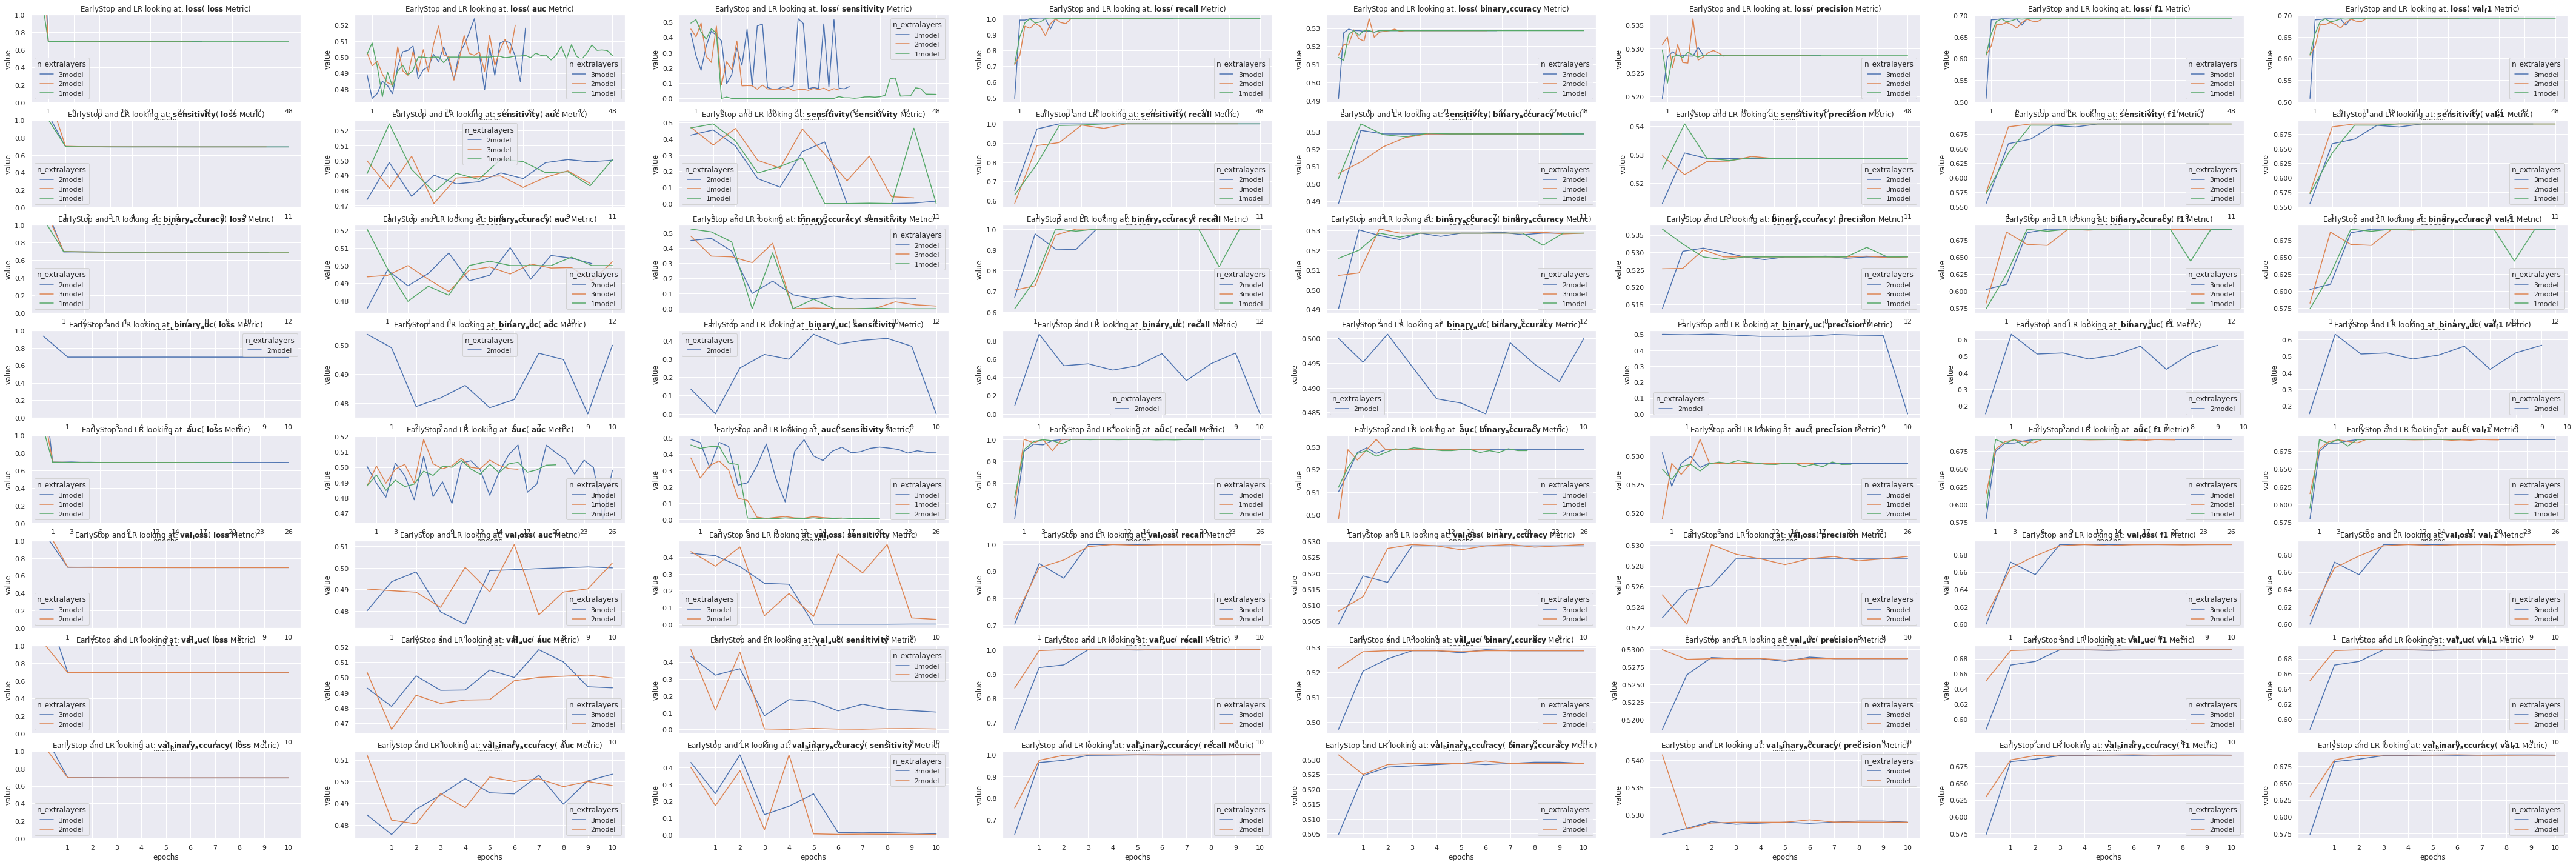

In [ ]:
metrics = ['auc', 
          'binary_accuracy', 'loss', 
          'sensitivity', 
          'precision', 'recall', 'f1', 'val_f1']
target_metrics = df_metrics_resnet.target_metric.unique()

df_present = df_metrics_resnet.loc[df_metrics_resnet.metric.isin(metrics) & 
                                   df_metrics_resnet.target_metric.isin(target_metrics)]
cols = df_present.metric.unique()
rows = df_present.target_metric.unique()

fig, axes = plt.subplots(len(rows), len(cols))

fig.set_figheight(25)
fig.set_figwidth(75)

sns.set()
axes = axes.ravel()

for row in range(len(rows) ):
    for col in range(len(cols)):
        i = row * len(cols) + col

        g = sns.lineplot(x="nepoch", y="value",
                    hue="n_extralayers",
                    data=df_present.loc[(df_present.metric == cols[col]) &
                                        (df_present.target_metric == rows[row])
                                       ],
                    ax=axes[i])

        last_epoch = g.get_xticks()[-1]
        g.set_xlabel('epochs')
        g.set_title(f'EarlyStop and LR looking at: ' +
                    r"$\bf{" + rows[row] +"}$"+ 
                    r"( $\bf{" + cols[col] +"}$ Metric)"
                   )
        g.set_xticks(np.linspace(1, last_epoch, 10, dtype=int))
        if cols[col] == 'loss':
          g.set_ylim((0, 1))

fig.savefig('metrics_resnet.png')


## VGG16

### **Loss** for monitor LR and EarlyStop

In [ ]:
my_model = build_my_model([1024, 512, 128], [0.5, 0.5, 0.5], model_name='VGG16')
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = 'loss',METRIC_MONITOR_MODE = 'min',  model_name='vgg16_loss_3_layers_')
save_history('history_training_vgg', 'history_3model_layer_loss', history)

In [ ]:
my_model = build_my_model([1024, 512], [0.5, 0.5], model_name='VGG16')
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = 'loss',METRIC_MONITOR_MODE = 'min',  model_name='vgg16_loss_2_layers_')
save_history('history_training_vgg', 'history_2model_layer_loss', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 14.8919 - auc: 0.4952 - binary_accuracy: 0.5295 - sensitivity: 0.4173 - fn: 182.0000 - fp: 959.0000 - tn: 184.0000 - tp: 1100.0000 - precision: 0.5342 - recall: 0.8580
Epoch 1: loss improved from inf to 14.89186, saving model to vgg16_loss_2_layers__my_model.best.hdf5
76/76 [==============================] - 62s 795ms/step - loss: 14.8919 - auc: 0.4952 - binary_accuracy: 0.5295 - sensitivity: 0.4173 - fn: 182.0000 - fp: 959.0000 - tn: 184.0000 - tp: 1100.0000 - precision: 0.5342 - recall: 0.8580 - val_loss: 0.7312 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6926 - auc: 0.5108 - binary_accuracy: 0.5254 - sensitivity: 0.4407 - fn: 156.0000 - fp: 995.0000 - tn: 148.0000 - tp: 1126.0

In [ ]:
my_model = build_my_model([512], [0.5], model_name='VGG16')
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = 'loss',METRIC_MONITOR_MODE = 'min',  model_name='vgg16_loss_1_layers_')
save_history('history_training_vgg', 'history_1model_layer_loss', history)

### **Sensitivity** for monitor LR and EarlyStop

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'sensitivity', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'sensitivity', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'sensitivity', 'max', [512], [0.5]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

### **Binary Accuracy** for monitor LR and EarlyStop

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'binary_accuracy', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'binary_accuracy', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 22.1654 - auc: 0.4786 - binary_accuracy: 0.5138 - sensitivity: 0.3721 - fn: 190.0000 - fp: 989.0000 - tn: 154.0000 - tp: 1092.0000 - precision: 0.5247 - recall: 0.8518
Epoch 1: binary_accuracy improved from -inf to 0.51381, saving model to vgg16_binary_accuracy_2_layers__my_model.best.hdf5
76/76 [==============================] - 64s 824ms/step - loss: 22.1654 - auc: 0.4786 - binary_accuracy: 0.5138 - sensitivity: 0.3721 - fn: 190.0000 - fp: 989.0000 - tn: 154.0000 - tp: 1092.0000 - precision: 0.5247 - recall: 0.8518 - val_loss: 0.7186 - val_auc: 0.4980 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 735.0000 - val_tn: 0.0000e+00 - val_tp: 147.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.7328 - auc: 0.4947 - binary_accuracy: 0.5258 - sensitivity: 0.4087 - fn: 35.0000 - fp: 1115.0000 - tn:

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'binary_accuracy', 'max', [512], [0.5]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

### **AUC** Accuracy for monitor LR and EarlyStop

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'auc', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'auc', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'auc', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

### **val_loss** Accuracy for monitor LR and EarlyStop

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_loss', 'min', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 11.9929 - auc: 0.5039 - binary_accuracy: 0.5241 - sensitivity: 0.5008 - fn: 251.0000 - fp: 903.0000 - tn: 240.0000 - tp: 1031.0000 - precision: 0.5331 - recall: 0.8042
Epoch 1: val_loss improved from inf to 0.69544, saving model to vgg16_val_loss_3_layers__my_model.best.hdf5
76/76 [==============================] - 63s 799ms/step - loss: 11.9929 - auc: 0.5039 - binary_accuracy: 0.5241 - sensitivity: 0.5008 - fn: 251.0000 - fp: 903.0000 - tn: 240.0000 - tp: 1031.0000 - precision: 0.5331 - recall: 0.8042 - val_loss: 0.6954 - val_auc: 0.5000 - val_binary_accuracy: 0.1678 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 734.0000 - val_tn: 1.0000 - val_tp: 147.0000 - val_precision: 0.1669 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.7838 - auc: 0.4862 - binary_accuracy: 0.5155 - sensitivity: 0.4345 - fn: 212.0000 - fp: 963.0000 - tn: 180.0000 - tp: 107

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_loss', 'min', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 14.1759 - auc: 0.4963 - binary_accuracy: 0.5053 - sensitivity: 0.4438 - fn: 494.0000 - fp: 709.0000 - tn: 434.0000 - tp: 795.0000 - precision: 0.5286 - recall: 0.6168
Epoch 1: val_loss improved from inf to 0.71686, saving model to vgg16_val_loss_2_layers__my_model.best.hdf5
76/76 [==============================] - 88s 972ms/step - loss: 14.1759 - auc: 0.4963 - binary_accuracy: 0.5053 - sensitivity: 0.4438 - fn: 494.0000 - fp: 709.0000 - tn: 434.0000 - tp: 795.0000 - precision: 0.5286 - recall: 0.6168 - val_loss: 0.7169 - val_auc: 0.4783 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.3071 - val_fn: 0.0000e+00 - val_fp: 700.0000 - val_tn: 0.0000e+00 - val_tp: 140.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6924 - auc: 0.4706 - binary_accuracy: 0.5300 - sensitivity: 0.3584 - fn: 0.0000e+00 - fp: 1143.0000 - tn: 0.0000e+00 - tp: 

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_loss', 'min', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 13.7695 - auc: 0.5116 - binary_accuracy: 0.5164 - sensitivity: 0.4833 - fn: 363.0000 - fp: 813.0000 - tn: 330.0000 - tp: 926.0000 - precision: 0.5325 - recall: 0.7184
Epoch 1: val_loss improved from inf to 0.80903, saving model to vgg16_val_loss_3_layers__my_model.best.hdf5
76/76 [==============================] - 66s 847ms/step - loss: 13.7695 - auc: 0.5116 - binary_accuracy: 0.5164 - sensitivity: 0.4833 - fn: 363.0000 - fp: 813.0000 - tn: 330.0000 - tp: 926.0000 - precision: 0.5325 - recall: 0.7184 - val_loss: 0.8090 - val_auc: 0.4986 - val_binary_accuracy: 0.1726 - val_sensitivity: 0.0000e+00 - val_fn: 3.0000 - val_fp: 692.0000 - val_tn: 8.0000 - val_tp: 137.0000 - val_precision: 0.1653 - val_recall: 0.9786 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6928 - auc: 0.4923 - binary_accuracy: 0.5267 - sensitivity: 0.4135 - fn: 16.0000 - fp: 1135.0000 - tn: 8.0000 - tp: 1273.0000 -

### **val_auc** Accuracy for monitor LR and EarlyStop

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_auc', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 20.6198 - auc: 0.4922 - binary_accuracy: 0.5181 - sensitivity: 0.4717 - fn: 198.0000 - fp: 974.0000 - tn: 169.0000 - tp: 1091.0000 - precision: 0.5283 - recall: 0.8464
Epoch 1: val_auc improved from -inf to 0.50000, saving model to vgg16_val_auc_3_layers__my_model.best.hdf5
76/76 [==============================] - 62s 792ms/step - loss: 20.6198 - auc: 0.4922 - binary_accuracy: 0.5181 - sensitivity: 0.4717 - fn: 198.0000 - fp: 974.0000 - tn: 169.0000 - tp: 1091.0000 - precision: 0.5283 - recall: 0.8464 - val_loss: 0.7184 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 700.0000 - val_tn: 0.0000e+00 - val_tp: 140.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6920 - auc: 0.4927 - binary_accuracy: 0.5292 - sensitivity: 0.4197 - fn: 4.0000 - fp: 1141.0000 - tn: 2.0000 - tp: 128

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_auc', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 16.5572 - auc: 0.4910 - binary_accuracy: 0.5144 - sensitivity: 0.4554 - fn: 132.0000 - fp: 1049.0000 - tn: 94.0000 - tp: 1157.0000 - precision: 0.5245 - recall: 0.8976
Epoch 1: val_auc improved from -inf to 0.50071, saving model to vgg16_val_auc_2_layers__my_model.best.hdf5
76/76 [==============================] - 79s 890ms/step - loss: 16.5572 - auc: 0.4910 - binary_accuracy: 0.5144 - sensitivity: 0.4554 - fn: 132.0000 - fp: 1049.0000 - tn: 94.0000 - tp: 1157.0000 - precision: 0.5245 - recall: 0.8976 - val_loss: 0.7021 - val_auc: 0.5007 - val_binary_accuracy: 0.1679 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 699.0000 - val_tn: 1.0000 - val_tp: 140.0000 - val_precision: 0.1669 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.7158 - auc: 0.5049 - binary_accuracy: 0.5308 - sensitivity: 0.4717 - fn: 18.0000 - fp: 1123.0000 - tn: 20.0000 - tp: 1271.

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_auc', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 11.8360 - auc: 0.5041 - binary_accuracy: 0.5115 - sensitivity: 0.4523 - fn: 312.0000 - fp: 876.0000 - tn: 267.0000 - tp: 977.0000 - precision: 0.5273 - recall: 0.7580
Epoch 1: val_auc improved from -inf to 0.50143, saving model to vgg16_val_auc_3_layers__my_model.best.hdf5
76/76 [==============================] - 64s 816ms/step - loss: 11.8360 - auc: 0.5041 - binary_accuracy: 0.5115 - sensitivity: 0.4523 - fn: 312.0000 - fp: 876.0000 - tn: 267.0000 - tp: 977.0000 - precision: 0.5273 - recall: 0.7580 - val_loss: 0.7025 - val_auc: 0.5014 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0071 - val_fn: 0.0000e+00 - val_fp: 700.0000 - val_tn: 0.0000e+00 - val_tp: 140.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.7033 - auc: 0.5155 - binary_accuracy: 0.5288 - sensitivity: 0.4531 - fn: 99.0000 - fp: 1047.0000 - tn: 96.0000 - tp: 1190.00

### **val_binary_accuracy** Accuracy for monitor LR and EarlyStop

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_binary_accuracy', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 18.7044 - auc: 0.4928 - binary_accuracy: 0.5078 - sensitivity: 0.4988 - fn: 409.0000 - fp: 788.0000 - tn: 355.0000 - tp: 880.0000 - precision: 0.5276 - recall: 0.6827
Epoch 1: val_binary_accuracy improved from -inf to 0.83333, saving model to vgg16_val_binary_accuracy_3_layers__my_model.best.hdf5
76/76 [==============================] - 62s 787ms/step - loss: 18.7044 - auc: 0.4928 - binary_accuracy: 0.5078 - sensitivity: 0.4988 - fn: 409.0000 - fp: 788.0000 - tn: 355.0000 - tp: 880.0000 - precision: 0.5276 - recall: 0.6827 - val_loss: 0.6837 - val_auc: 0.5000 - val_binary_accuracy: 0.8333 - val_sensitivity: 0.0000e+00 - val_fn: 140.0000 - val_fp: 0.0000e+00 - val_tn: 700.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6926 - auc: 0.4942 - binary_accuracy: 0.5267 - sensitivity: 0.3879 - fn: 103.0000 - fp: 

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_binary_accuracy', 'max', [1024, 128], [0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 19.9363 - auc: 0.5053 - binary_accuracy: 0.5304 - sensitivity: 0.4678 - fn: 169.0000 - fp: 973.0000 - tn: 170.0000 - tp: 1120.0000 - precision: 0.5351 - recall: 0.8689
Epoch 1: val_binary_accuracy improved from -inf to 0.16667, saving model to vgg16_val_binary_accuracy_2_layers__my_model.best.hdf5
76/76 [==============================] - 62s 790ms/step - loss: 19.9363 - auc: 0.5053 - binary_accuracy: 0.5304 - sensitivity: 0.4678 - fn: 169.0000 - fp: 973.0000 - tn: 170.0000 - tp: 1120.0000 - precision: 0.5351 - recall: 0.8689 - val_loss: 0.7101 - val_auc: 0.5000 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 700.0000 - val_tn: 0.0000e+00 - val_tp: 140.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.6924 - auc: 0.5000 - binary_accuracy: 0.5296 - sensitivity: 0.3390 - fn: 2.0000 - fp: 1142.000

In [ ]:
model_name = 'VGG16'
monitor, mode, n_layers, dropout = 'val_binary_accuracy', 'max', [1024, 512, 128], [0.5, 0.5, 0.3]

my_model = build_my_model(n_layers, dropout, model_name=model_name)
history = training(my_model, train_gen, valX, valY, METRIC_MONITOR = monitor, METRIC_MONITOR_MODE = mode,  model_name=f'{model_name.lower()}_{monitor.lower()}_{len(n_layers)}_layers_')
save_history('history_training_vgg', f'history_{len(n_layers)}model_layer_{monitor}', history)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 17.7382 - auc: 0.4874 - binary_accuracy: 0.5189 - sensitivity: 0.4127 - fn: 192.0000 - fp: 978.0000 - tn: 165.0000 - tp: 1097.0000 - precision: 0.5287 - recall: 0.8510
Epoch 1: val_binary_accuracy improved from -inf to 0.16667, saving model to vgg16_val_binary_accuracy_3_layers__my_model.best.hdf5
76/76 [==============================] - 64s 820ms/step - loss: 17.7382 - auc: 0.4874 - binary_accuracy: 0.5189 - sensitivity: 0.4127 - fn: 192.0000 - fp: 978.0000 - tn: 165.0000 - tp: 1097.0000 - precision: 0.5287 - recall: 0.8510 - val_loss: 0.7099 - val_auc: 0.4993 - val_binary_accuracy: 0.1667 - val_sensitivity: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 700.0000 - val_tn: 0.0000e+00 - val_tp: 140.0000 - val_precision: 0.1667 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.7013 - auc: 0.4979 - binary_accuracy: 0.5164 - sensitivity: 0.4112 - fn: 263.0000 - fp: 913.00

### Analyse Results

In [ ]:
import os
import pandas as pd
import json
import numpy as np
import seaborn as sns

path = 'history_training_vgg'
folders = [f for f in os.listdir(path) if not os.path.isfile(f)]
data = np.array([])
for d in folders:
    for f in [f for f in
             os.listdir(f'{path}/{d}') if os.path.isfile(f'{path}/{d}/{f}')]:
        if f == 'lr.json': continue
        info = json.load(open(f'{path}/{d}/{f}', 'r'))
        n_ele = len(info)
        tmp = np.array([list(range(n_ele)), [d] * n_ele, [f.replace('.json','')] * n_ele, info ])
        if len(data) == 0: 
            data = tmp
        else: 
            data = np.concatenate([data,tmp], axis=1)

df_metrics_vgg = pd.DataFrame(data.T, columns=['nepoch','name', 'metric', 'value'])
df_metrics_vgg['n_extralayers'] = df_metrics_vgg.name.apply(lambda x:x.split('_')[1])
df_metrics_vgg['target_metric'] = df_metrics_vgg.name.apply(lambda x:"_".join(x.split('_')[x.split('_').index('layer')+1:]))
df_metrics_vgg['value'] = pd.to_numeric(df_metrics_vgg['value'] )

In [ ]:
for model in df_metrics_vgg['n_extralayers'].unique():
    for target_metric in df_metrics_vgg['target_metric'].unique():
        tmp = df_metrics_vgg.loc[(df_metrics_vgg['n_extralayers'] == model) &
                                 (df_metrics_vgg['target_metric'] == target_metric)]
        recall    = tmp.loc[tmp['metric'] == 'recall', 'value'].values
        precision = tmp.loc[tmp['metric'] == 'precision', 'value'].values
        tp        = tmp.loc[tmp['metric'] == 'tp', 'value'].values
        fp        = tmp.loc[tmp['metric'] == 'fp', 'value'].values        
        nepoch    = tmp.loc[tmp['metric'] == 'precision', 'nepoch'].values
        name      = tmp.loc[tmp['metric'] == 'precision', 'name'].values
        f1        = 2 * (precision * recall) / (precision + recall)

        val_precision = tmp.loc[tmp['metric'] == 'val_precision', 'value'].values
        val_recall    = tmp.loc[tmp['metric'] == 'val_recall', 'value'].values
        val_f1        = 2 * (val_precision * val_recall) / (val_precision + val_recall)

        new_f1 = pd.DataFrame({'nepoch':nepoch, 'name': name,
                                        'metric': np.full((len(f1)), 'f1'),
                                        'value': f1, 'n_extralayers': np.full((len(f1)), model),
                                        'target_metric': np.full((len(f1)), target_metric)
                        })

        new_val_f1 = pd.DataFrame({'nepoch':nepoch, 'name': name,
                                        'metric': np.full((len(val_f1)), 'val_f1'),
                                        'value': f1, 'n_extralayers': np.full((len(f1)), model),
                                        'target_metric': np.full((len(f1)), target_metric)
                        })

        df_metrics_vgg = df_metrics_vgg.append(new_f1)
        df_metrics_vgg = df_metrics_vgg.append(new_val_f1)        

df_metrics_vgg = df_metrics_vgg.reset_index()
df_metrics_vgg.drop('index', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


<Figure size 1440x1080 with 0 Axes>

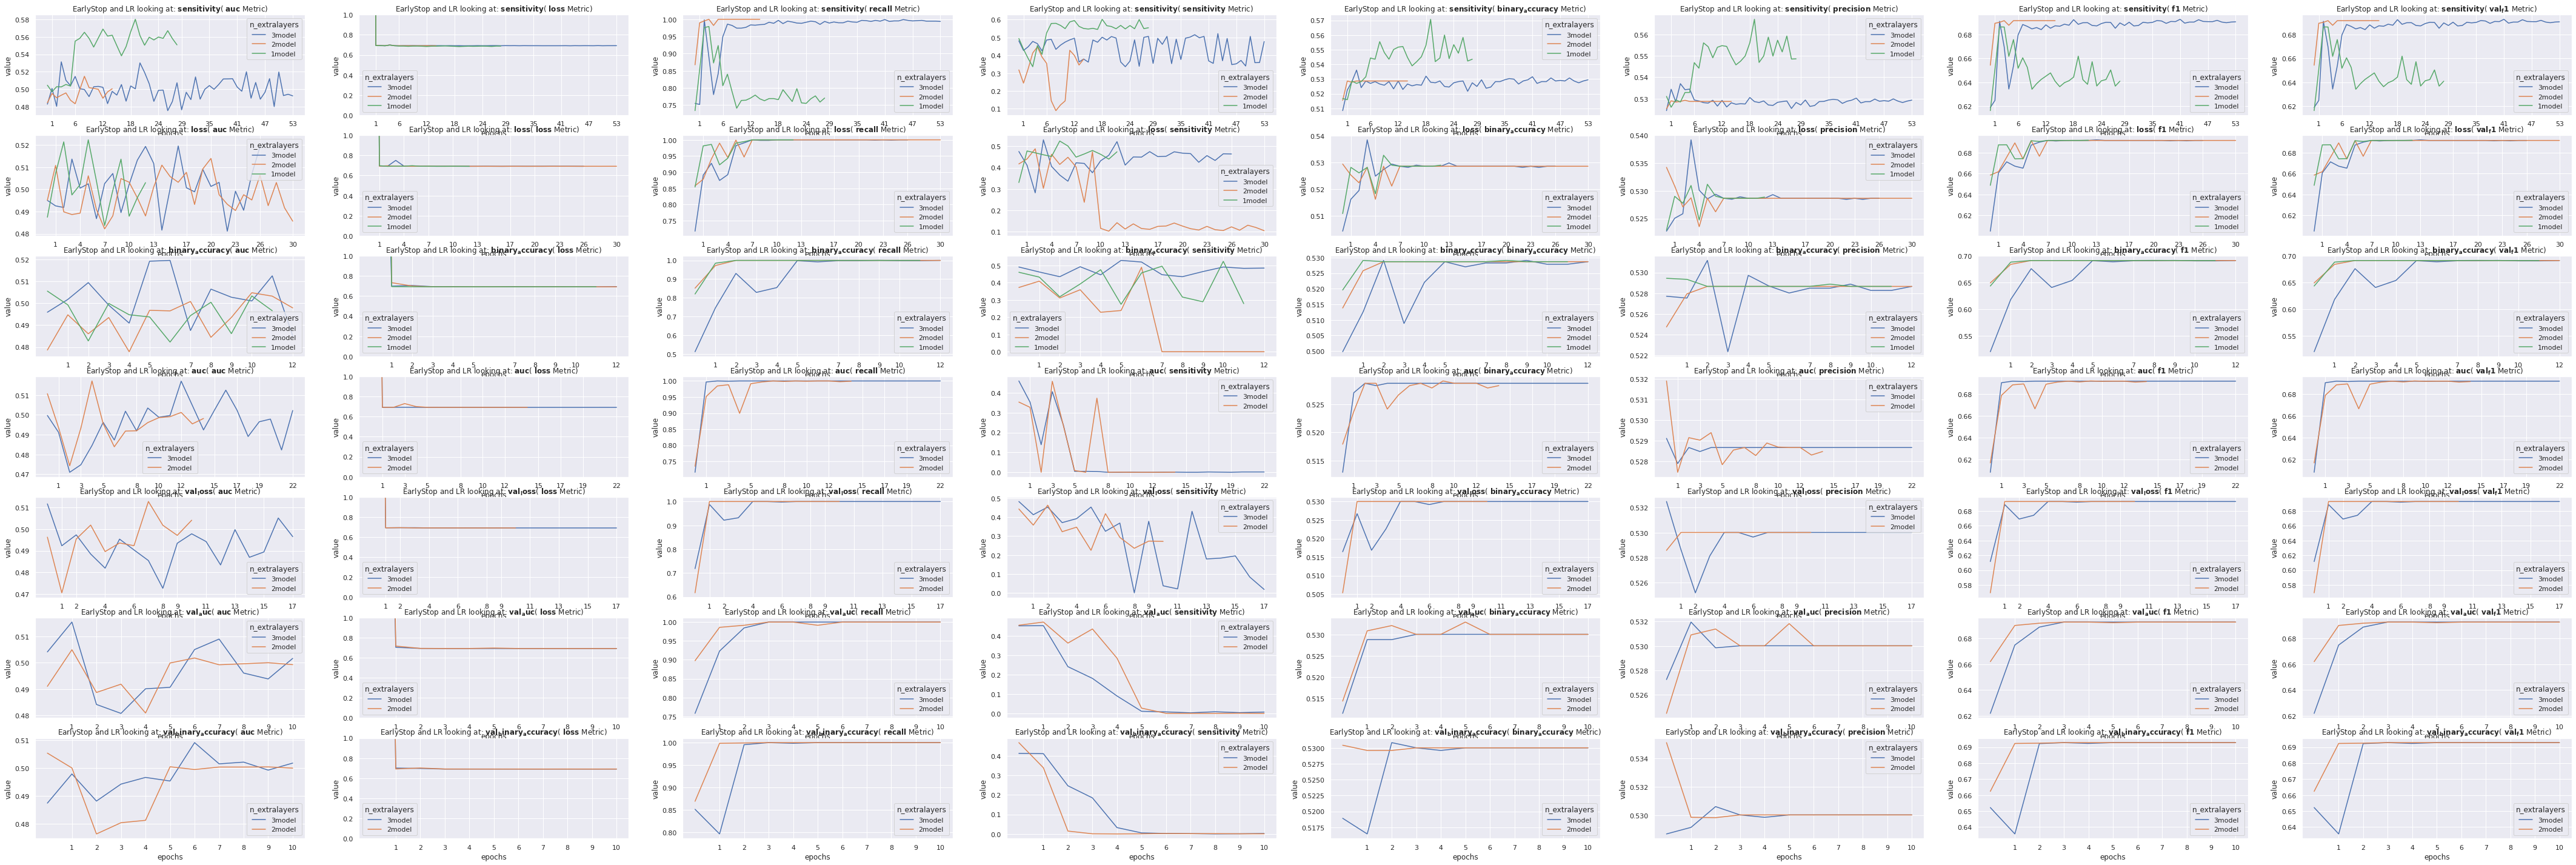

In [ ]:
metrics = ['auc', 
          'binary_accuracy', 'loss', 
          'sensitivity', 
          'precision', 'recall', 'f1', 'val_f1']
target_metrics = df_metrics_vgg.target_metric.unique()

df_present = df_metrics_vgg.loc[df_metrics_vgg.metric.isin(metrics) & 
                                 df_metrics_vgg.target_metric.isin(target_metrics)]
cols = df_present.metric.unique()
rows = df_present.target_metric.unique()
plt.figure(figsize=(20,15))
fig, axes = plt.subplots(len(rows), len(cols))

fig.set_figheight(25)
fig.set_figwidth(75)
# g = sns.relplot(x="index", y="value", kind='line',
sns.set()
axes = axes.ravel()

for row in range(len(rows) ):
    for col in range(len(cols)):
        i = row * len(cols) + col
        #print(row, col, i)
#        fig.add_subplot(len(rows), len(cols), i)
        g = sns.lineplot(x="nepoch", y="value",
                    hue="n_extralayers",
                    data=df_present.loc[(df_present.metric == cols[col]) &
                                        (df_present.target_metric == rows[row])
                                       ],
                    ax=axes[i])
        #n_epochs = 
        last_epoch = g.get_xticks()[-1]
        g.set_xlabel('epochs')
        g.set_title(f'EarlyStop and LR looking at: ' +
                    r"$\bf{" + rows[row] +"}$"+ 
                    r"( $\bf{" + cols[col] +"}$ Metric)"
                   )
        g.set_xticks(np.linspace(1, last_epoch, 10, dtype=int))
        if cols[col] == 'loss':
          g.set_ylim((0, 1))
fig.savefig('metrics_vgg.png')
#        print(type(g))

# Test

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.


def test_model(fig, row, n_rows,  valX, valY, best_model_path, layers, dropouts, model_name):
  my_model = build_my_model(layers, dropouts, model_name=model_name)
  my_model.load_weights(best_model_path)
  pred_y = my_model.predict(valX, batch_size = 32, verbose = False)
  
  plot_auc(fig, row,  n_rows, valY, pred_y)
  plot_precision_recall_curve(fig, row,  n_rows, valY, pred_y)
  plot_f1_threshold(fig, row,  n_rows, valY, pred_y)


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, confusion_matrix

def plot_auc(fig, row, n_rows, t_y, p_y):
    #fig, ax = plt.subplots(1,1, figsize = (10, 10))
    ax = fig.add_subplot(n_rows, 3, row * 3 + 1 )
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = f'Pneumnia (AUC:{auc(fpr, tpr):.2f})')
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    return fpr, tpr, thresholds
    
    
def plot_precision_recall_curve(fig, row, n_rows,  t_y, p_y):
    ax = fig.add_subplot(n_rows, 3, row * 3 + 2 )
    prec, recall, thresholds = precision_recall_curve(t_y, p_y)
    val = average_precision_score(t_y, p_y)
    ax.plot(prec, recall, label = f'Pneumnia (Average Precision: {val:.2f})')
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precission')
    
    return prec, recall, thresholds

def plot_f1_threshold(fig, row, n_rows, t_y, p_y):
    ax = fig.add_subplot(n_rows, 3, row * 3 + 3 )
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1 = 2*(precision*recall)/(precision+recall)
    f1_max = np.nanmax(f1)
    n = np.where(f1 == f1_max)
    
    ax.plot(thresholds, f1[:len(thresholds)], label = 'F1 vs Thresholds')
    ax.scatter(thresholds[n], f1_max, c='red', s=10)
    text_color = f' Max f1: {f1_max:.4f} (th: {thresholds[n][0]:.2f})'
    
    ax.annotate(text_color, xy=(thresholds[n], f1_max) ,xycoords='data',c='r')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1')

    
    

### Test outcome of models:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7

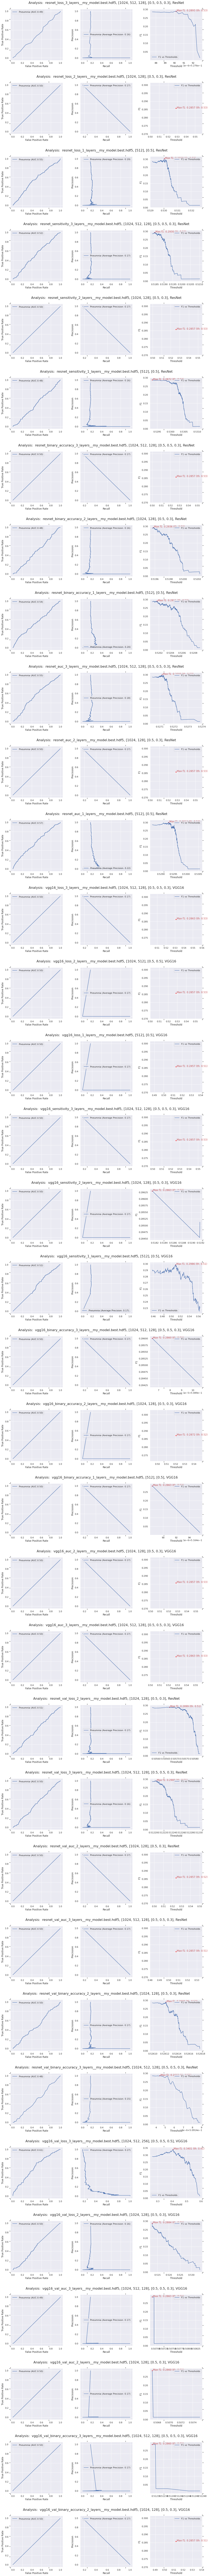

In [ ]:
saved_models = [f for f in os.listdir('.') if f.endswith('.hdf5')]

fig, big_axes = plt.subplots(figsize=(15, (5*len(saved_models))) , nrows=len(saved_models), ncols=1, sharey=True) 

for row, filename in enumerate(saved_models):
#for i in range(1,10):
#    ax = fig.add_subplot(3,3,i)
#    ax.set_title('Plot title ' + str(i))

    model_name = 'ResNet' if 'resnet' in filename else 'VGG16'
    if filename == 'vgg16_loss_2_layers__my_model.best.hdf5': 
      layers, dropouts = [1024, 512], [0.5, 0.5]
    elif filename == 'vgg16_val_loss_3_layers__my_model.best.hdf5': 
      layers, dropouts = [1024, 512, 256], [0.5, 0.5, 0.5]
    elif '3_layers' in filename:
      layers, dropouts = [1024, 512, 128], [0.5, 0.5, 0.3]
    elif '2_layers' in filename:
      layers, dropouts = [1024, 128], [0.5, 0.3]
    else:
      layers, dropouts = [512], [0.5]

    big_axes[row].set_title(f"Analysis:  {filename}, {layers}, {dropouts}, {model_name}\n", fontsize=16)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_axes[row].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_axes[row]._frameon = False
    
    #ax = fig.add_subplot(3,3,i)

    # print(filename)
    test_model(fig, row, len(saved_models), valX, valY, filename, layers, dropouts, model_name)

fig.set_facecolor('w')
fig.savefig('test_vgg_resnet.png')
plt.tight_layout()
plt.show()



# Choose best model and save

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

**Answer:** As we can see from above exercise and image, the best model is a VGG16 for this DataSet (unlike a ResNet50 as previously thought) and 3 layers (1024, 512, 256) with 3 dropouts (0.5, 0.5, 0.5). For the model to work better, it is best that we use a Threshold of 0.41

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
YOUR_THRESHOLD = 0.41

best_model_path, layers, dropouts, model_name = 'vgg16_val_loss_3_layers__my_model.best.hdf5', [1024, 512, 256], [0.5, 0.5, 0.5], 'VGG16'

my_model = build_my_model(layers, dropouts, model_name=model_name)
my_model.load_weights(best_model_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)


26/26 [==============================] - 2s 78ms/step


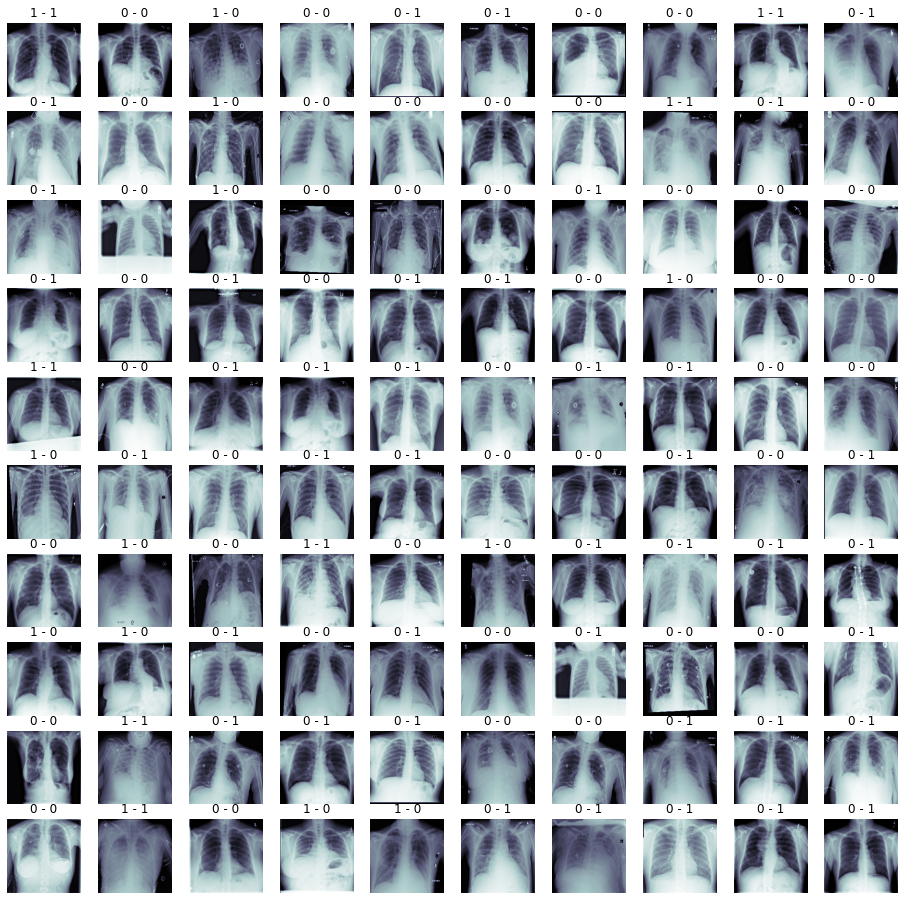

In [ ]:

# Todo
index_sample = np.random.randint(len(valX), size=(100))
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[index_sample], valY[index_sample], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] >= YOUR_THRESHOLD:
            c_ax.set_title('1 - 1')
        else:
            c_ax.set_title('1 - 0')
    else:
        if pred_Y[i] >= YOUR_THRESHOLD: 
            c_ax.set_title('0 - 1')
        else:
            c_ax.set_title('0 - 0')
    c_ax.axis('off')
    i += 1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_best_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from sklearn.metrics import classification_report
pred = (pred_Y > YOUR_THRESHOLD).astype(int)
print(classification_report(valY, pred))

              precision    recall  f1-score   support

         0.0       0.86      0.53      0.66       675
         1.0       0.19      0.57      0.29       135

    accuracy                           0.54       810
   macro avg       0.53      0.55      0.47       810
weighted avg       0.75      0.54      0.59       810



In [ ]:
from sklearn.metrics import confusion_matrix, recall_score,precision_score

print(recall_score(valY, pred), precision_score(valY, pred))

0.5703703703703704 0.1949367088607595
